# 3nd Research Question:
### Is there a connection between number of friends and religious words usage?

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import PowerNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import pearsonr
import seaborn as sns

# --- Load and preprocess data ---

df = pd.read_csv("cleaned_students_data.csv")
df["NumberOffriends"] = pd.to_numeric(df["NumberOffriends"], errors="coerce")
df = df.dropna(subset=["NumberOffriends"])

TARGET_TOTAL = 3000
sample_df = df.sample(n=min(TARGET_TOTAL, len(df)), random_state=42).reset_index(drop=True)
print(f"Sampled {len(sample_df)} students for analysis.")

# Group number of friends into bins
sample_df['friends_group'] = pd.cut(sample_df['NumberOffriends'],
                                    bins=[-1, 2, 10, 20, 30, 40, 50, 100, float('inf')],
                                    labels=['0-2', '3-10', '11-20', '21-30', '31-40', '41-50', '51-100', '101+'],
                                    right=True)
print("\nRows per friends group after grouping:")
print(sample_df['friends_group'].value_counts().sort_index())

RELIGIOUS_WORDS = ['god', 'church', 'jesus', 'bible']
RELIGIOUS_WORDS = [w for w in RELIGIOUS_WORDS if w in sample_df.columns]
sample_df[RELIGIOUS_WORDS] = sample_df[RELIGIOUS_WORDS].apply(pd.to_numeric, errors="coerce").fillna(0)
print(f"Using religious words: {RELIGIOUS_WORDS}")

sample_df["religion_total"] = sample_df[RELIGIOUS_WORDS].sum(axis=1)
corr = sample_df[["NumberOffriends", "religion_total"]].corr().iloc[0,1]
print(f"Correlation between number of friends and religious word usage: r = {corr:.3f}")

# --- Function to create religious words network ---
def make_religion_graph(indices):
    B = (sample_df.loc[indices, RELIGIOUS_WORDS] > 0).astype(int).values
    shared = B @ B.T
    np.fill_diagonal(shared, 0)

    G = nx.Graph()
    for pos, idx in enumerate(indices):
        row = sample_df.loc[idx]
        G.add_node(int(idx), friends=int(row["NumberOffriends"]), gender=row.get("gender", None))

    k = len(indices)
    for i in range(k):
        for j in range(i+1, k):
            w = int(shared[i, j])
            if w > 0:
                G.add_edge(indices[i], indices[j], weight=w)
    return G

# Build general religion network
general_indices = sample_df.index.tolist()
religion_G = make_religion_graph(general_indices)
print(f"\nGeneral religion network: nodes={religion_G.number_of_nodes()}, edges={religion_G.number_of_edges()}")

# --- Analysis functions ---

def analyze_subnetwork(G, group_name):
    print(f"\nAnalyzing sub-network: {group_name}")
    
    # 1. Average clustering coefficient
    avg_clustering = nx.average_clustering(G, weight='weight')
    
    # 2. Betweenness centrality (weighted)
    bet_centrality = nx.betweenness_centrality(G, weight='weight', normalized=True)
    avg_betweenness = np.mean(list(bet_centrality.values()))
    
    # 3. Node strength (sum of edge weights per node)
    strengths = dict(G.degree(weight='weight'))
    avg_strength = np.mean(list(strengths.values()))
    
    # Strength distribution stats
    strength_vals = np.array(list(strengths.values()))
    median_strength = np.median(strength_vals)
    std_strength = np.std(strength_vals)
    min_strength = strength_vals.min() if len(strength_vals) > 0 else 0
    max_strength = strength_vals.max() if len(strength_vals) > 0 else 0
    skewness = pd.Series(strength_vals).skew() if len(strength_vals) > 0 else 0
    
    print(f"Average clustering coefficient: {avg_clustering:.4f}")
    print(f"Average betweenness centrality: {avg_betweenness:.4f}")
    print(f"Average strength: {avg_strength:.4f}")
    print(f"Strength distribution stats - median: {median_strength:.2f}, std: {std_strength:.2f}, min: {min_strength}, max: {max_strength}, skewness: {skewness:.2f}")
    
    # 4. Attribute-edge correlation: correlation between node's number of friends and sum of weights (strength)
    friends_list = []
    strength_list = []
    for n, d in G.nodes(data=True):
        friends_list.append(d['friends'])
        strength_list.append(strengths[n])
    if len(friends_list) > 1:
        corr_attr_edge, p_val = pearsonr(friends_list, strength_list)
    else:
        corr_attr_edge, p_val = (np.nan, np.nan)
    print(f"Attribute-edge Pearson correlation (friends vs strength): r = {corr_attr_edge:.3f}, p = {p_val:.3g}")
    
    return {
        'average_clustering': avg_clustering,
        'average_betweenness': avg_betweenness,
        'average_strength': avg_strength,
        'strength_distribution': strength_vals,
        'attribute_edge_corr': corr_attr_edge,
        'attribute_edge_pval': p_val,
        'strength_stats': {
            'median': median_strength,
            'std': std_strength,
            'min': min_strength,
            'max': max_strength,
            'skewness': skewness
        }
    }

# --- Assortativity and Mixing Ratio on general network ---

def calculate_assortativity_mixing(G):
    # We need to assign the 'friends_group' attribute for nodes in G
    for n, d in G.nodes(data=True):
        idx = n
        # Get friends_group from sample_df
        d['friends_group'] = sample_df.loc[idx, 'friends_group']
    
    # Remove nodes without group info
    nodes_with_group = [n for n, d in G.nodes(data=True) if pd.notna(d['friends_group'])]
    H = G.subgraph(nodes_with_group).copy()

    # Convert friends_group categories to integers for assortativity (assortativity_numeric)
    groups = list(sample_df['friends_group'].cat.categories)
    group_to_int = {g: i for i, g in enumerate(groups)}
    nx.set_node_attributes(H, {n: group_to_int[d['friends_group']] for n, d in H.nodes(data=True)}, 'friends_group_int')

    # Assortativity by friends_group_int attribute
    assort = nx.attribute_assortativity_coefficient(H, 'friends_group_int')
    print(f"\nAssortativity by friends group (general network): {assort:.4f}")

    # Mixing ratio = (# edges crossing groups) / (# edges within groups)
    within = 0
    cross = 0
    for u, v in H.edges():
        if H.nodes[u]['friends_group'] == H.nodes[v]['friends_group']:
            within += 1
        else:
            cross += 1
    mixing_ratio = cross / within if within > 0 else np.nan
    print(f"Mixing ratio (num of cross-group edges / num of within-group edges): {mixing_ratio:.4f}")

    return assort, mixing_ratio

# --- Run analysis ---

group_order = ['0-2', '3-10', '11-20', '21-30', '31-40', '41-50', '51-100', '101+']
friends_groups = [g for g in group_order if g in sample_df['friends_group'].unique()]
print(f"\n'Num of Friends' groups found: {friends_groups}")

results = {}

# Analyze general network (only clustering, assortativity, mixing)
results['general_network'] = {}
results['general_network']['average_clustering'] = nx.average_clustering(religion_G, weight='weight')
print(f"\nGeneral network average clustering coefficient: {results['general_network']['average_clustering']:.4f}")

assortativity, mixing_ratio = calculate_assortativity_mixing(religion_G)
results['general_network']['assortativity'] = assortativity
results['general_network']['mixing_ratio'] = mixing_ratio

# Analyze sub-networks
for group in friends_groups:
    indices = sample_df[sample_df['friends_group'] == group].index.tolist()
    if not indices:
        print(f"\nSkipping '{group}' group (no data).")
        continue

    G = make_religion_graph(indices)
    print(f"\n{group} Num of Friends network: nodes={G.number_of_nodes()}, edges={G.number_of_edges()}")

    if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
        print(f"\nSkipping '{group}' group (empty or unconnected).")
        continue

    res = analyze_subnetwork(G, group)
    results[group] = res


Sampled 3000 students for analysis.

Rows per friends group after grouping:
friends_group
0-2       591
3-10      425
11-20     470
21-30     360
31-40     320
41-50     234
51-100    496
101+      104
Name: count, dtype: int64
Using religious words: ['god', 'church', 'jesus', 'bible']
Correlation between number of friends and religious word usage: r = 0.070

General religion network: nodes=3000, edges=429142

'Num of Friends' groups found: ['0-2', '3-10', '11-20', '21-30', '31-40', '41-50', '51-100', '101+']

General network average clustering coefficient: 0.0956

Assortativity by friends group (general network): -0.0012
Mixing ratio (num of cross-group edges / num of within-group edges): 6.3047

0-2 Num of Friends network: nodes=591, edges=11353

Analyzing sub-network: 0-2
Average clustering coefficient: 0.1022
Average betweenness centrality: 0.0001
Average strength: 40.8460
Strength distribution stats - median: 0.00, std: 67.54, min: 0, max: 237, skewness: 1.31
Attribute-edge Pearso

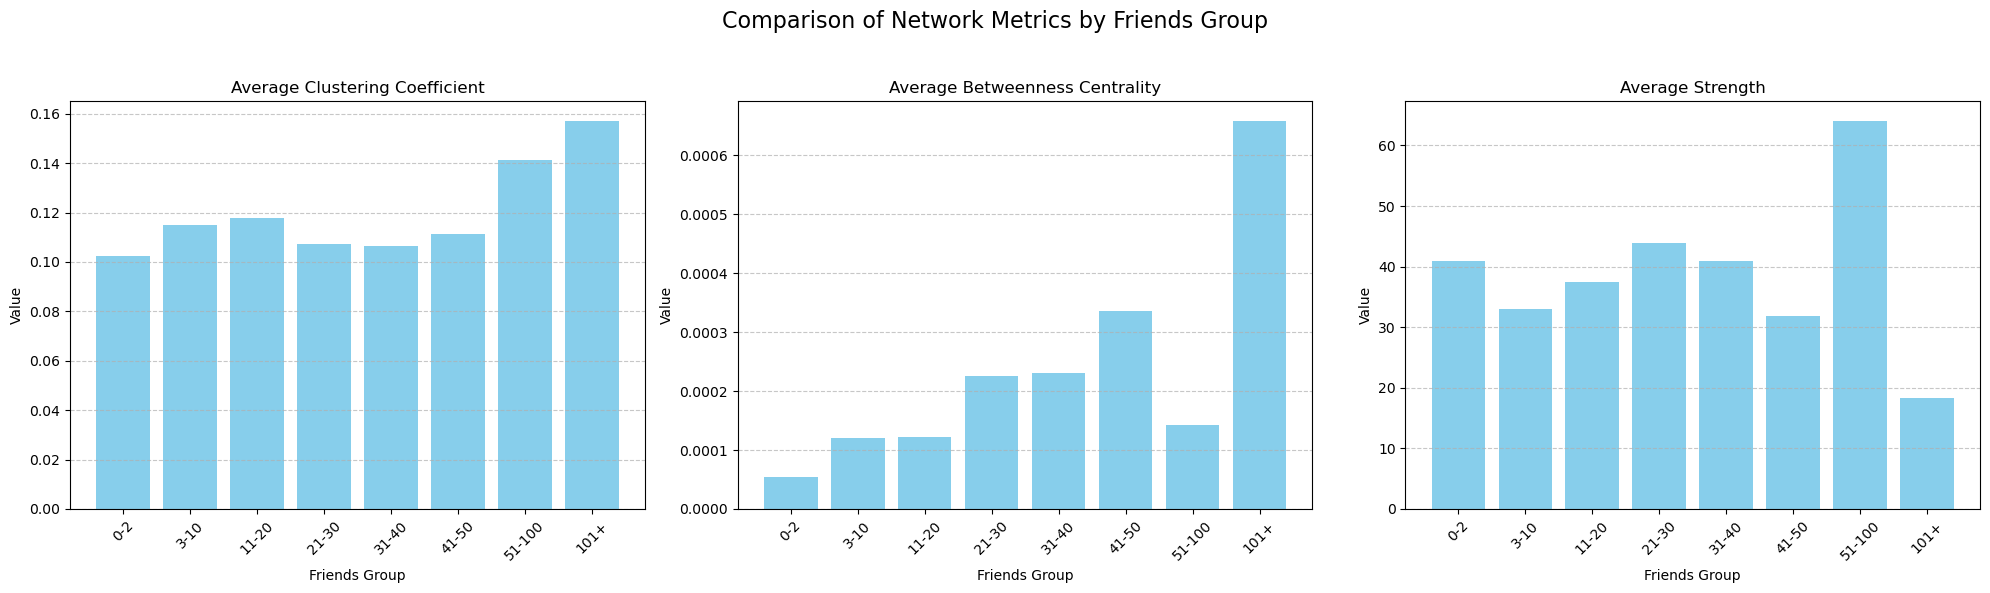

C:\Users\amits\AppData\Local\Temp\ipykernel_13940\1844746341.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Friends Group', y='Strength', data=strength_df, palette='Pastel1', showfliers=True)


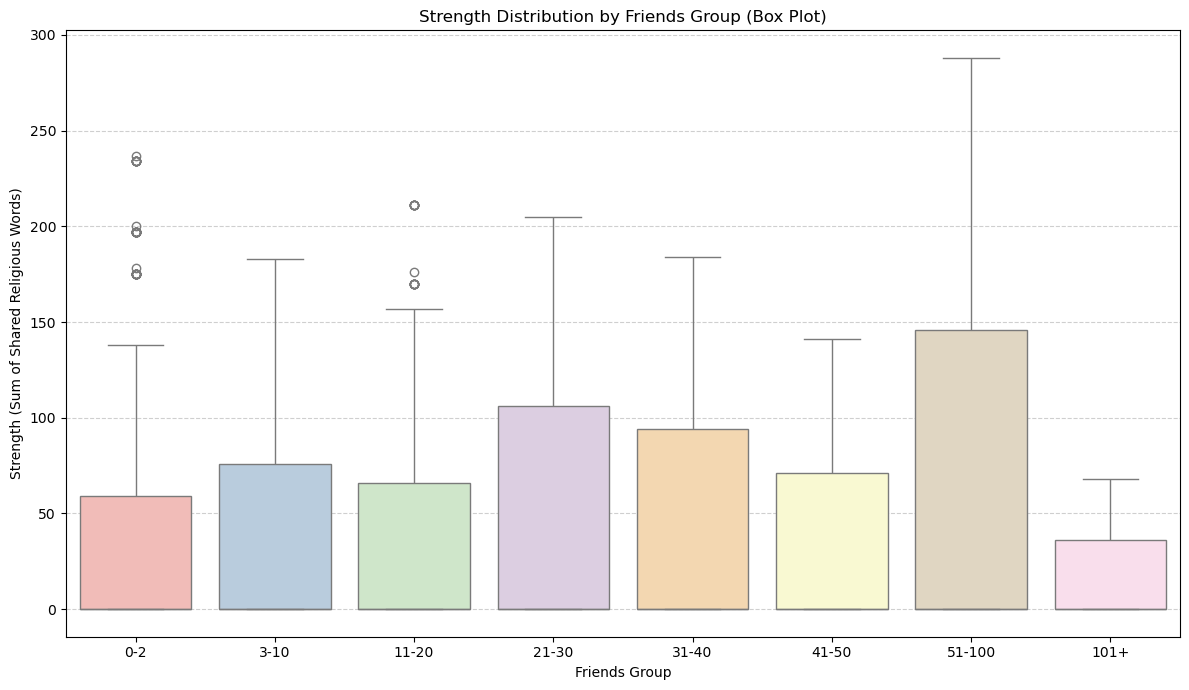

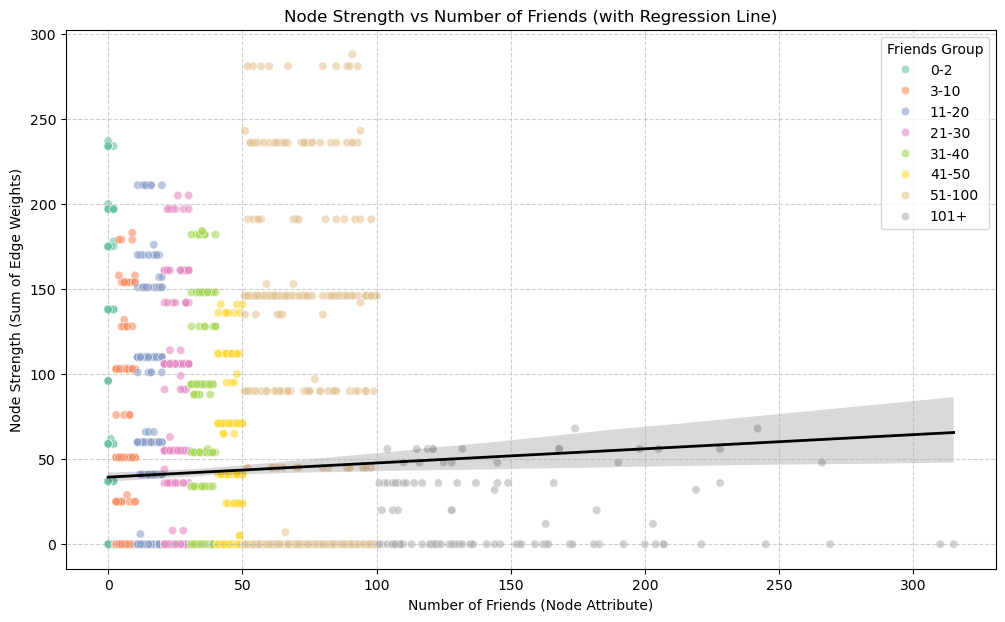


Analysis complete.


In [5]:
# --- Visualization ---

# 1. Bar plots of average clustering, betweenness, strength per group

metrics = ['average_clustering', 'average_betweenness', 'average_strength']
metric_names = ['Average Clustering Coefficient', 'Average Betweenness Centrality', 'Average Strength']

fig, axs = plt.subplots(1, 3, figsize=(20, 6))
for i, metric in enumerate(metrics):
    vals = [results[g][metric] for g in friends_groups]
    axs[i].bar(friends_groups, vals, color='skyblue')
    axs[i].set_title(metric_names[i])
    axs[i].set_xlabel('Friends Group')
    axs[i].set_ylabel('Value')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(True, axis='y', linestyle='--', alpha=0.7)
plt.suptitle('Comparison of Network Metrics by Friends Group', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# 2. Strength distributions box plots
plt.figure(figsize=(12, 7))
strength_data = []
for g in friends_groups:
    vals = results[g]['strength_distribution']
    strength_data.extend([(g, v) for v in vals])
strength_df = pd.DataFrame(strength_data, columns=['Friends Group', 'Strength'])

sns.boxplot(x='Friends Group', y='Strength', data=strength_df, palette='Pastel1', showfliers=True)
plt.title('Strength Distribution by Friends Group (Box Plot)')
plt.xlabel('Friends Group')
plt.ylabel('Strength (Sum of Shared Religious Words)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# 3. Scatter plot for attribute-edge correlation (friends vs strength) per group
# Combine all nodes from all groups for a single regression
all_friends = []
all_strengths = []
all_groups = []

for g in friends_groups:
    indices = sample_df[sample_df['friends_group'] == g].index.tolist()
    G = make_religion_graph(indices)
    strengths = dict(G.degree(weight='weight'))
    for n in G.nodes:
        all_friends.append(G.nodes[n]['friends'])
        all_strengths.append(strengths[n])
        all_groups.append(g)

# Create a DataFrame for plotting
trend_df = pd.DataFrame({
    'Number of Friends': all_friends,
    'Strength': all_strengths,
    'Friends Group': all_groups
})

# Plot with regression line
plt.figure(figsize=(12, 7))
sns.scatterplot(data=trend_df, x='Number of Friends', y='Strength', hue='Friends Group', alpha=0.6, palette='Set2')
sns.regplot(data=trend_df, x='Number of Friends', y='Strength', scatter=False, color='black', line_kws={"linewidth": 2})
plt.xlabel('Number of Friends (Node Attribute)')
plt.ylabel('Node Strength (Sum of Edge Weights)')
plt.title('Node Strength vs Number of Friends (with Regression Line)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Friends Group')
plt.show()


# --- Finished ---
print("\nAnalysis complete.")


Running Independent Cascade simulations per friends group...
0-2: Avg cascade size = 130.23 (out of 591)
3-10: Avg cascade size = 102.07 (out of 425)
11-20: Avg cascade size = 142.93 (out of 470)
21-30: Avg cascade size = 136.40 (out of 360)
31-40: Avg cascade size = 106.50 (out of 320)
41-50: Avg cascade size = 67.73 (out of 234)
51-100: Avg cascade size = 204.37 (out of 496)
101+: Avg cascade size = 20.17 (out of 104)


C:\Users\amits\AppData\Local\Temp\ipykernel_13940\3245608068.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=groups, y=avg_cascades, palette='coolwarm')


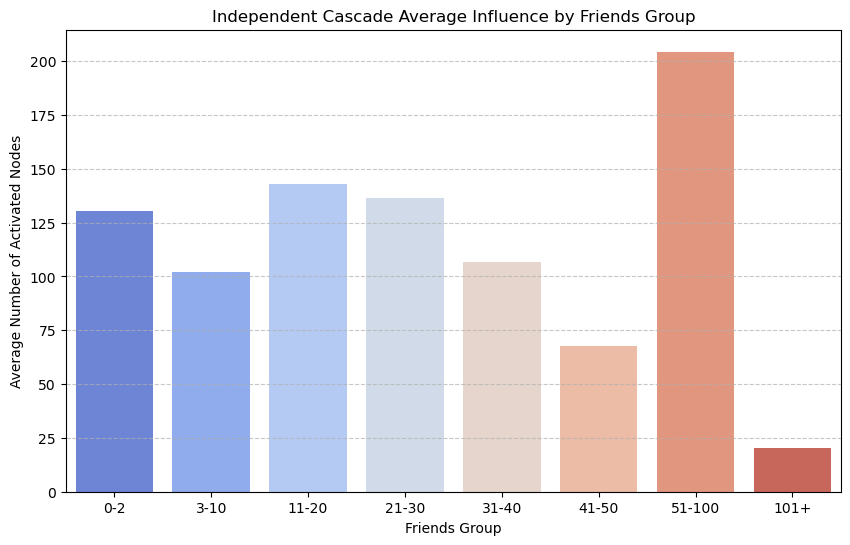


Running Louvain community detection on general network...
Number of communities found: 1849


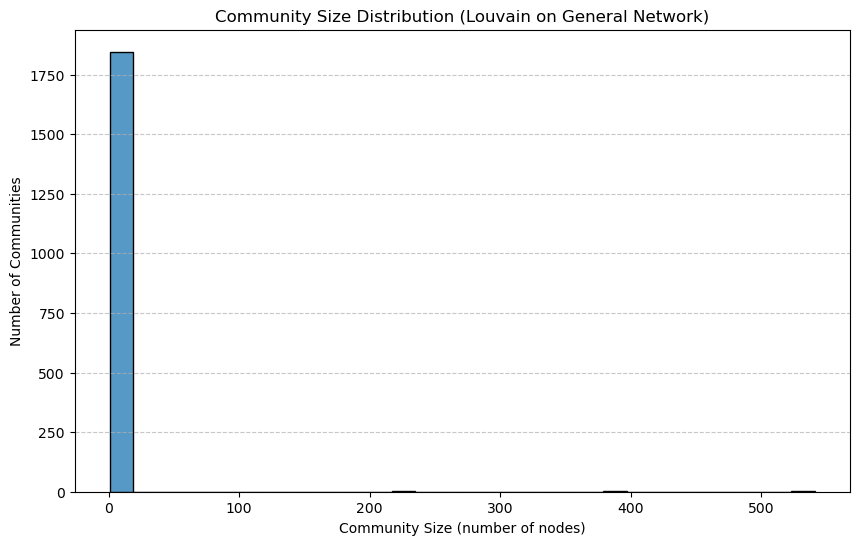

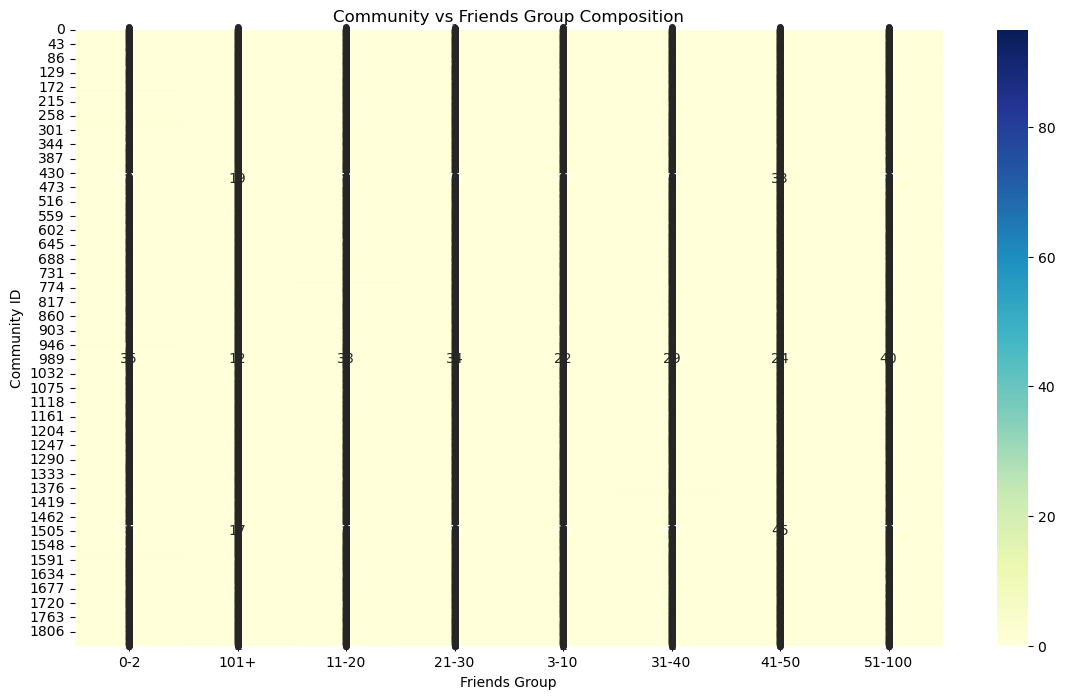


Filtering edges with weight < 2 in general network...
Edges removed: 400133, Nodes isolated and removed: 2681
Remaining graph: nodes=319, edges=29009


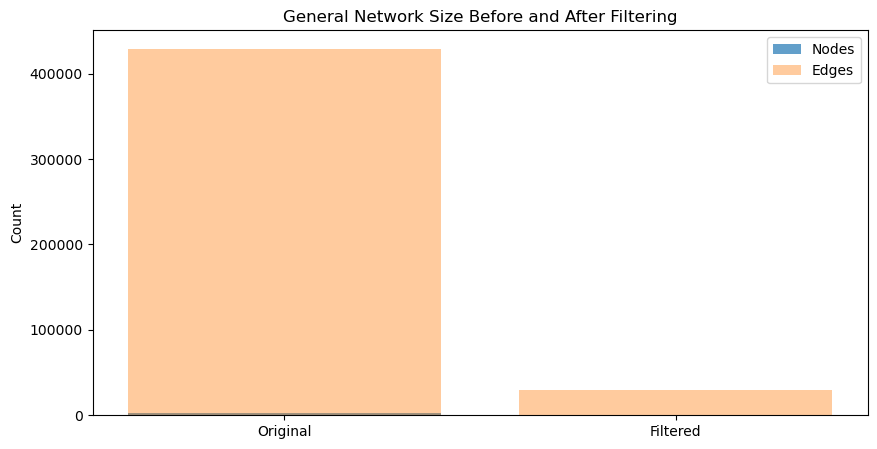


Filtering edges in sub-networks...
0-2: Nodes 591 -> 48, Edges 11353 -> 679 (removed edges: 10674)
  Isolated nodes removed: 543
3-10: Nodes 425 -> 29, Edges 6789 -> 218 (removed edges: 6571)
  Isolated nodes removed: 396
11-20: Nodes 470 -> 42, Edges 8343 -> 452 (removed edges: 7891)
  Isolated nodes removed: 428
21-30: Nodes 360 -> 41, Edges 7453 -> 429 (removed edges: 7024)
  Isolated nodes removed: 319
31-40: Nodes 320 -> 40, Edges 6040 -> 471 (removed edges: 5569)
  Isolated nodes removed: 280
41-50: Nodes 234 -> 30, Edges 3365 -> 325 (removed edges: 3040)
  Isolated nodes removed: 204
51-100: Nodes 496 -> 67, Edges 14571 -> 1259 (removed edges: 13312)
  Isolated nodes removed: 429
101+: Nodes 104 -> 22, Edges 835 -> 118 (removed edges: 717)
  Isolated nodes removed: 82


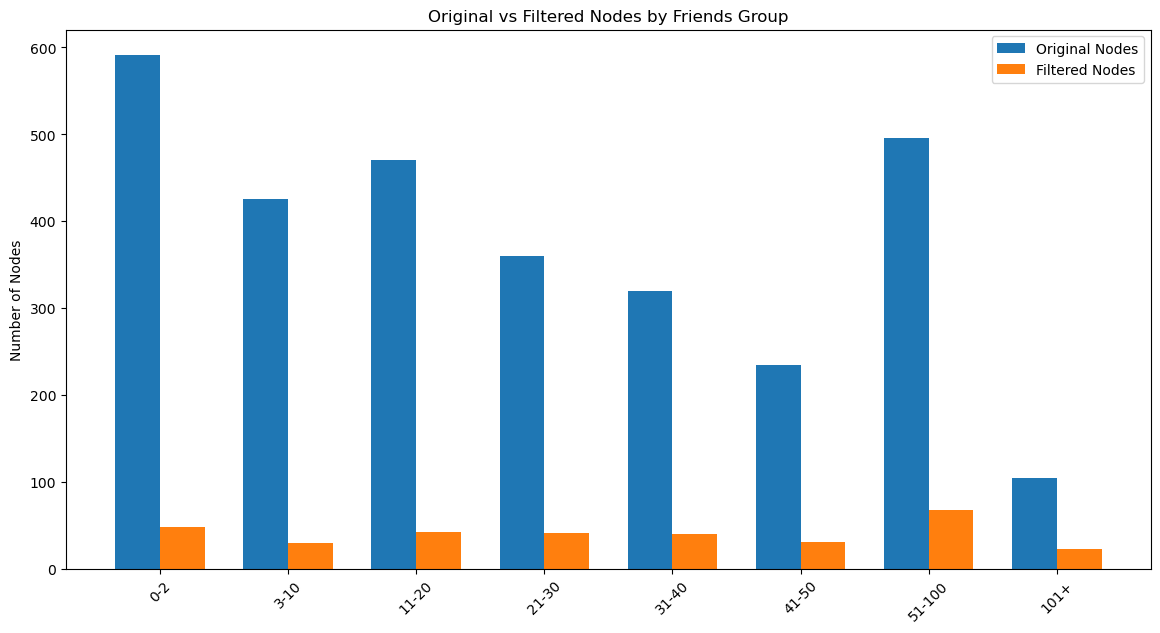

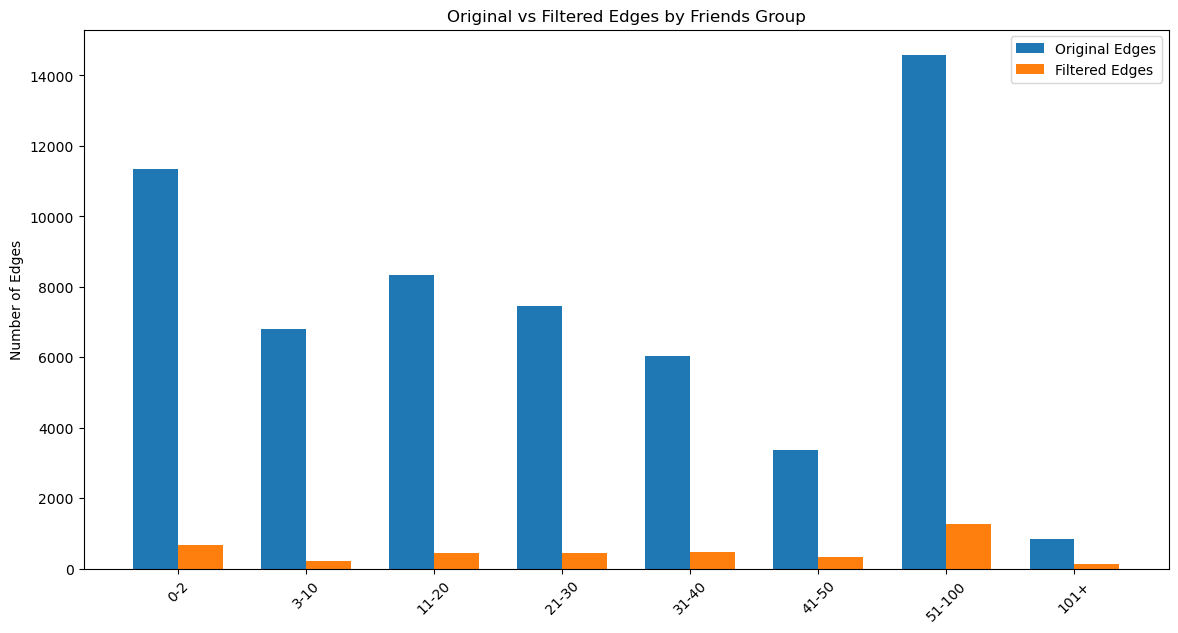


--- Simulation and community detection completed ---


In [6]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain  # for Louvain algorithm
from collections import defaultdict
from tqdm import tqdm

# --- Assuming your sample_df and religion_G (general network) are already defined as before ---

# --- 1. Independent Cascade (IC) Model Simulation --- #

def independent_cascade(G, seeds, p=0.1, steps=10):
    """
    Simulate the Independent Cascade diffusion process on graph G.
    seeds: list of initially activated nodes
    p: activation probability per edge
    steps: max simulation steps
    Returns activated nodes set.
    """
    activated = set(seeds)
    newly_activated = set(seeds)

    for step in range(steps):
        next_activated = set()
        for node in newly_activated:
            neighbors = set(G.neighbors(node)) - activated
            for nbr in neighbors:
                if np.random.rand() < p:
                    next_activated.add(nbr)
        if not next_activated:
            break
        activated.update(next_activated)
        newly_activated = next_activated
    return activated

def run_ic_multiple(G, seed_frac=0.01, p=0.1, steps=10, n_runs=20):
    """
    Run IC simulation multiple times with random seed sets.
    Returns average cascade size and list of influence sizes per run.
    """
    node_list = list(G.nodes())
    seed_size = max(1, int(seed_frac * len(node_list)))
    cascade_sizes = []

    for _ in range(n_runs):
        seeds = np.random.choice(node_list, seed_size, replace=False)
        activated = independent_cascade(G, seeds, p=p, steps=steps)
        cascade_sizes.append(len(activated))
    avg_cascade = np.mean(cascade_sizes)
    return avg_cascade, cascade_sizes

# Run IC on each sub-network (friends groups)
print("\nRunning Independent Cascade simulations per friends group...")
ic_results = {}
for group in friends_groups:
    indices = sample_df[sample_df['friends_group'] == group].index.tolist()
    G_sub = make_religion_graph(indices)
    if G_sub.number_of_nodes() == 0 or G_sub.number_of_edges() == 0:
        print(f"Skipping IC for '{group}' due to empty or disconnected graph.")
        continue
    avg_cascade, cascades = run_ic_multiple(G_sub, seed_frac=0.01, p=0.1, steps=10, n_runs=30)
    ic_results[group] = {'avg_cascade': avg_cascade, 'all_cascades': cascades}
    print(f"{group}: Avg cascade size = {avg_cascade:.2f} (out of {G_sub.number_of_nodes()})")

# Visualization of IC results
plt.figure(figsize=(10,6))
groups = list(ic_results.keys())
avg_cascades = [ic_results[g]['avg_cascade'] for g in groups]
sns.barplot(x=groups, y=avg_cascades, palette='coolwarm')
plt.title("Independent Cascade Average Influence by Friends Group")
plt.xlabel("Friends Group")
plt.ylabel("Average Number of Activated Nodes")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- 2. Louvain Community Detection on General Network --- #

print("\nRunning Louvain community detection on general network...")
partition = community_louvain.best_partition(religion_G, weight='weight')
nx.set_node_attributes(religion_G, partition, 'community')

# Count communities and size
community_counts = defaultdict(int)
for comm in partition.values():
    community_counts[comm] += 1

print(f"Number of communities found: {len(community_counts)}")

# Plot community size distribution
comm_sizes = list(community_counts.values())
plt.figure(figsize=(10,6))
sns.histplot(comm_sizes, bins=30, kde=False)
plt.title("Community Size Distribution (Louvain on General Network)")
plt.xlabel("Community Size (number of nodes)")
plt.ylabel("Number of Communities")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# Check community composition by friends groups
community_df = pd.DataFrame({
    'node': list(partition.keys()),
    'community': list(partition.values())
})
community_df['friends_group'] = community_df['node'].map(lambda x: sample_df.loc[x, 'friends_group'])

comm_group_counts = community_df.groupby(['community', 'friends_group']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
sns.heatmap(comm_group_counts, cmap='YlGnBu', annot=True, fmt='d')
plt.title("Community vs Friends Group Composition")
plt.xlabel("Friends Group")
plt.ylabel("Community ID")
plt.show()

# --- 3. Filter Weak Edges (General + Subnetworks) --- #

def filter_weak_edges(G, weight_threshold=2):
    """
    Remove edges with weight below threshold.
    Return filtered graph.
    """
    G_filtered = G.copy()
    to_remove = [(u,v) for u,v,d in G.edges(data=True) if d['weight'] < weight_threshold]
    G_filtered.remove_edges_from(to_remove)
    # Also remove isolated nodes (no edges)
    isolated = list(nx.isolates(G_filtered))
    G_filtered.remove_nodes_from(isolated)
    return G_filtered, len(to_remove), len(isolated)

# Threshold
weight_thresh = 2

print(f"\nFiltering edges with weight < {weight_thresh} in general network...")
G_filtered, edges_removed, nodes_removed = filter_weak_edges(religion_G, weight_threshold=weight_thresh)
print(f"Edges removed: {edges_removed}, Nodes isolated and removed: {nodes_removed}")
print(f"Remaining graph: nodes={G_filtered.number_of_nodes()}, edges={G_filtered.number_of_edges()}")

# Plot size before and after filtering
sizes = [religion_G.number_of_nodes(), G_filtered.number_of_nodes()]
edges = [religion_G.number_of_edges(), G_filtered.number_of_edges()]
plt.figure(figsize=(10,5))
plt.bar(['Original', 'Filtered'], sizes, alpha=0.7, label='Nodes')
plt.bar(['Original', 'Filtered'], edges, alpha=0.4, label='Edges')
plt.ylabel('Count')
plt.title('General Network Size Before and After Filtering')
plt.legend()
plt.show()

# Repeat filtering on sub-networks and report connectivity
print("\nFiltering edges in sub-networks...")
filtering_results = {}
for group in friends_groups:
    indices = sample_df[sample_df['friends_group'] == group].index.tolist()
    G_sub = make_religion_graph(indices)
    if G_sub.number_of_nodes() == 0:
        print(f"Skipping '{group}' sub-network due to no nodes.")
        continue
    G_filt, rem_edges, rem_nodes = filter_weak_edges(G_sub, weight_threshold=weight_thresh)
    filtering_results[group] = {
        'original_nodes': G_sub.number_of_nodes(),
        'original_edges': G_sub.number_of_edges(),
        'filtered_nodes': G_filt.number_of_nodes(),
        'filtered_edges': G_filt.number_of_edges(),
        'removed_edges': rem_edges,
        'removed_nodes': rem_nodes
    }
    print(f"{group}: Nodes {G_sub.number_of_nodes()} -> {G_filt.number_of_nodes()}, Edges {G_sub.number_of_edges()} -> {G_filt.number_of_edges()} (removed edges: {rem_edges})")
    if rem_nodes > 0:
        print(f"  Isolated nodes removed: {rem_nodes}")

# Optional visualization: plot filtered vs original nodes and edges per group
groups_filt = list(filtering_results.keys())
nodes_original = [filtering_results[g]['original_nodes'] for g in groups_filt]
nodes_filtered = [filtering_results[g]['filtered_nodes'] for g in groups_filt]
edges_original = [filtering_results[g]['original_edges'] for g in groups_filt]
edges_filtered = [filtering_results[g]['filtered_edges'] for g in groups_filt]

x = np.arange(len(groups_filt))
width = 0.35

fig, ax = plt.subplots(figsize=(14,7))
rects1 = ax.bar(x - width/2, nodes_original, width, label='Original Nodes')
rects2 = ax.bar(x + width/2, nodes_filtered, width, label='Filtered Nodes')
ax.set_ylabel('Number of Nodes')
ax.set_title('Original vs Filtered Nodes by Friends Group')
ax.set_xticks(x)
ax.set_xticklabels(groups_filt, rotation=45)
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(14,7))
rects1 = ax.bar(x - width/2, edges_original, width, label='Original Edges')
rects2 = ax.bar(x + width/2, edges_filtered, width, label='Filtered Edges')
ax.set_ylabel('Number of Edges')
ax.set_title('Original vs Filtered Edges by Friends Group')
ax.set_xticks(x)
ax.set_xticklabels(groups_filt, rotation=45)
ax.legend()
plt.show()

print("\n--- Simulation and community detection completed ---")
